In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from enm.utils import *

# Giant component size change

In [2]:
cpcc = pd.read_csv('../data/interim/costanzo_pcc_ALL')

In [3]:
def get_giant_component(G):
    Gc = max([G.subgraph(c).copy() for c in nx.connected_components(G)], key=len)
    return Gc

In [4]:
ne_ratio_list = []
nv_ratio_list = []

In [5]:
thr_list =  [0.05,0.1,0.2,0.25,0.3,0.35,0.4]

In [6]:
for i in np.arange(0.2,0.75,0.05):
    df = cpcc.loc[cpcc.pcc>=i]
    nw = nx.from_pandas_edgelist(df,source='gene1',target='gene2')
    nw_g = get_giant_component(nw)
    n_e = len(nw_g.edges)
    ne_ratio_list.append(n_e/len(nw.edges))
    n_v = len(nw_g.nodes)
    nv_ratio_list.append(n_v/len(nw.nodes))

    print(f"{i} : ne = {n_e}, ne_ratio: {n_e/len(nw.edges)}, nv = {n_v}, nv_ratio = {n_v/len(nw.nodes)}")

0.2 : ne = 39816, ne_ratio: 0.9987457984247228, nv = 5183, nv_ratio = 0.9831183611532626
0.25 : ne = 20810, ne_ratio: 0.9893505752591043, nv = 3924, nv_ratio = 0.932287954383464
0.3 : ne = 10973, ne_ratio: 0.9426166136929817, nv = 2615, nv_ratio = 0.7960426179604262
0.35 : ne = 5857, ne_ratio: 0.8150570553854718, nv = 1686, nv_ratio = 0.646968534151957
0.39999999999999997 : ne = 862, ne_ratio: 0.21034651049292338, nv = 280, nv_ratio = 0.1423487544483986
0.44999999999999996 : ne = 246, ne_ratio: 0.10967454302273741, nv = 105, nv_ratio = 0.07553956834532374
0.49999999999999994 : ne = 93, ne_ratio: 0.07795473595976529, nv = 57, nv_ratio = 0.06168831168831169
0.5499999999999999 : ne = 26, ne_ratio: 0.044905008635578586, nv = 18, nv_ratio = 0.03180212014134275
0.5999999999999999 : ne = 20, ne_ratio: 0.07662835249042145, nv = 9, nv_ratio = 0.030303030303030304
0.6499999999999999 : ne = 10, ne_ratio: 0.08333333333333333, nv = 6, nv_ratio = 0.0379746835443038
0.7 : ne = 6, ne_ratio: 0.12, nv =

In [7]:
xlab = "Pearson's Correlation Coefficient threshold"

Text(0.5, 0, "Pearson's Correlation Coefficient threshold")

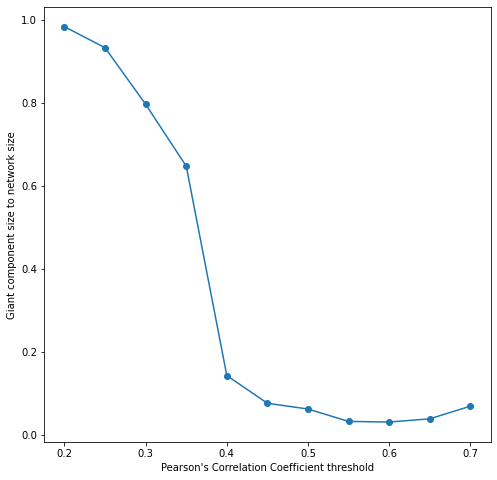

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(np.arange(0.2,0.75,0.05),nv_ratio_list,'o-')
ax.set_ylabel('Giant component size to network size')
ax.set_xlabel(xlab)

# Effector and sensor clusters with GO enrichments

In [9]:
sensor_df_names = [ ]

In [10]:
effector_dfs = get_result_dfs('effectors_df', thr_list)

In [11]:
sensor_dfs =  get_result_dfs('sensors_df', thr_list)

In [12]:
effector_sensor_go_dfs = get_result_dfs('effector_sensor_combined_go_df',thr_list)

In [13]:
sensor_dfs[0.2].dropna(subset=['sensor_cluster']).loc[:,'sensor_cluster'].nunique()

9

In [14]:
def plot_go_thr_comparison(dfs, col, yaxis,plotname, xlab='PCC Threshold'):
    n_goterms = []
    rat_goterms = []
    n_clusters = []
    n_go_clusters = []
    for i in thr_list:
        df = dfs[i]
        n_goterms.append(df.dropna(subset=['go_group']).shape[0])
        rat_goterms.append(n_goterms[-1]/df.shape[0])
        n_clusters.append(df.dropna(subset=[col]).loc[:,col].nunique())
        n_go_clusters.append(df.dropna(subset=[col]).loc[:,'go_group'].nunique())
        
    fig, axs = plt.subplots(1,2,figsize=(5,2.5))
    axs[0].plot(thr_list, n_clusters, 'o-')
    axs[0].set_ylabel(f'Number of {yaxis} clusters', fontsize=12)
    axs[0].set_xlabel(xlab, fontsize=12)
    
    axs[1].plot(thr_list, n_go_clusters, 'o-')
    axs[1].set_ylabel(f'Number of go enriched\n{yaxis} clusters', fontsize=12)
    axs[1].set_xlabel(xlab, fontsize=12)
    
    plt.tight_layout()
    fig.savefig(f'../reports/figures/paper_figures_supp/{plotname}.png', bbox_inches='tight', dpi=150)
    # axs[2].plot(thr_list, [i/j if i!=0 else 0 for i,j in zip(n_go_clusters,n_clusters) ], 'o-')
    # axs[2].set_ylabel(f'% of go enriched {yaxis} clusters')
    # axs[2].set_xlabel(xlab)

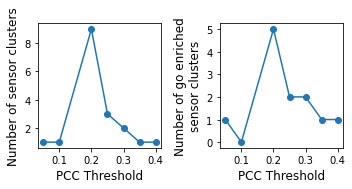

In [15]:
plot_go_thr_comparison(sensor_dfs,'sensor_cluster', 'sensor',plotname='thr_num_sensor_clusters')

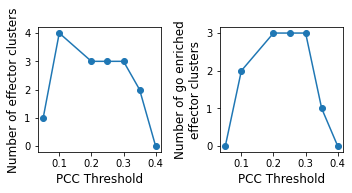

In [17]:
plot_go_thr_comparison(effector_dfs,'effector_cluster', 'effector',plotname='thr_num_effector_clusters')

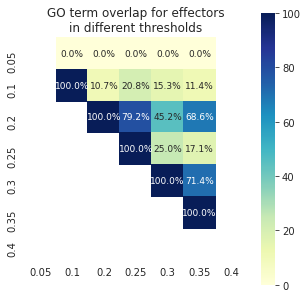

In [18]:
#effector_sensor_go_dfs
go_overlap = pd.DataFrame({thr : [len(np.intersect1d(effector_sensor_go_dfs[thr].loc[effector_sensor_go_dfs[thr].cluster_type=='effector','GO'], effector_sensor_go_dfs[i].loc[effector_sensor_go_dfs[i].cluster_type=='effector','GO'])) for i in thr_list] for thr in sorted(thr_list)})
go_overlap.index = thr_list
def plot_heatmap_overlap(df, filename, title , cmap='YlGnBu' , figsize = (10,6)):
    import seaborn as sns
    mask = np.zeros_like(df)
    mask[np.tril_indices_from(mask, k=-1)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(100*df/ np.diag(df),annot=True, mask= mask, square=True, vmax=100, cbar=True, ax=ax, fmt='.1f',cmap=cmap)
        ax.set_title(title)
        
        for t in ax.texts: 
            t.set_text(t.get_text() + "%")
            t.set_size(9)
        ax.set_xlabel(ax.get_xlabel(),fontsize=16)
    plt.savefig(f'../reports/figures/paper_figures_supp/{filename}.png', bbox_inches='tight',dpi=150)    

plot_heatmap_overlap(go_overlap, 'go_overlap_test', 'GO term overlap for effectors\nin different thresholds', figsize=(5,5))

In [19]:

sensor_overlap = pd.DataFrame({thr : [len(np.intersect1d(sensor_dfs[thr].orf_name, sensor_dfs[i].orf_name)) for i in thr_list] for thr in sorted(thr_list)})
sensor_overlap.index = thr_list

effector_overlap = pd.DataFrame({thr : [len(np.intersect1d(effector_dfs[thr].orf_name, effector_dfs[i].orf_name)) for i in thr_list] for thr in sorted(thr_list)})
effector_overlap.index = thr_list

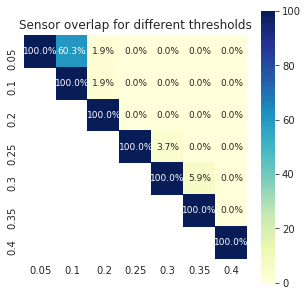

In [20]:
plot_heatmap_overlap(sensor_overlap, 'sensor_overlap', 'Sensor overlap for different thresholds', figsize=(5,5))

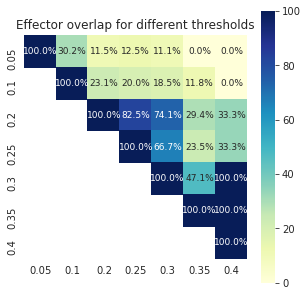

In [21]:
plot_heatmap_overlap(effector_overlap, 'effector_overlap', 'Effector overlap for different thresholds', figsize=(5,5))